# Predicting Breast Cancer - A Classification Problem

**Data:**     
The UCI Machine Learning Repository breast cancer Wisconsin dataset was used for this notebook; it can be found by following the link: https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic)

Features are computed from a digitised image of a fine needle aspirate (FNA) of a breast mass, and describe characteristics of the cell nuclei present in the image.

Attribute in the dataset include:
+ ID number
+ Diagnosis (M = malignant, B = benign)
+ Attributes 3-32 are 10 real-valued features computed for each cell nucleus:
    + radius (mean of distances from center to points on the perimeter)
    + texture (standard deviation of gray-scale values)
    + perimeter
    + area
    + smoothness (local variation in radius lengths)
    + compactness (perimeter^2 / area - 1.0)
    + concavity (severity of concave portions of the contour)
    + concave points (number of concave portions of the contour)
    + symmetry
    + fractal dimension ("coastline approximation" - 1)

The dataset is relatively balanced - approximately 37% cases are malignant and 63% are benign.    

A number of classifiers will be trialled on the dataset - K-fold cross validation will be used and performance of the classifier evaluated. Once individual models have been used, classifiers will be stacked to see if this improves performance over individual models. The best performed will then be trained and tested on the unseen test data.

## 1. Loading the data

In [2]:
#import modules
import numpy as np
import pandas as pd
import time
import sys, os
from sklearn.model_selection import train_test_split 
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from urllib.request import urlopen 

from sklearn.neighbors import KNeighborsClassifier 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.neural_network import MLPClassifier 
from sklearn.metrics import roc_curve 
from sklearn.metrics import auc
from sklearn.externals import joblib
from sklearn.metrics import classification_report
from terminaltables import AsciiTable

%matplotlib inline

pd.set_option('display.max_columns', 500) 
plt.style.use('ggplot') #ggplot2 style visuals

In [3]:
#loading data and cleaning dataset
UCI_data_URL = 'https://archive.ics.uci.edu/ml/machine-learning-databases\
/breast-cancer-wisconsin/wdbc.data'

names = ['id_number', 'diagnosis', 'radius_mean', 
         'texture_mean', 'perimeter_mean', 'area_mean', 
         'smoothness_mean', 'compactness_mean', 
         'concavity_mean','concave_points_mean', 
         'symmetry_mean', 'fractal_dimension_mean',
         'radius_se', 'texture_se', 'perimeter_se', 
         'area_se', 'smoothness_se', 'compactness_se', 
         'concavity_se', 'concave_points_se', 
         'symmetry_se', 'fractal_dimension_se', 
         'radius_worst', 'texture_worst', 
         'perimeter_worst', 'area_worst', 
         'smoothness_worst', 'compactness_worst', 
         'concavity_worst', 'concave_points_worst', 
         'symmetry_worst', 'fractal_dimension_worst'] 

breast_cancer = pd.read_csv(urlopen(UCI_data_URL), names=names)

# Setting 'id_number' as our index
breast_cancer.set_index(['id_number'], inplace = True) 

# For later use in CART models
namesInd = names[2:]

## 2. Data Exploration

In [ ]:
breast_cancer.head()

In [4]:
#dimensions of df
breast_cancer.shape

(569, 31)

In [5]:
#data types
breast_cancer.dtypes

diagnosis                   object
radius_mean                float64
texture_mean               float64
perimeter_mean             float64
area_mean                  float64
smoothness_mean            float64
compactness_mean           float64
concavity_mean             float64
concave_points_mean        float64
symmetry_mean              float64
fractal_dimension_mean     float64
radius_se                  float64
texture_se                 float64
perimeter_se               float64
area_se                    float64
smoothness_se              float64
compactness_se             float64
concavity_se               float64
concave_points_se          float64
symmetry_se                float64
fractal_dimension_se       float64
radius_worst               float64
texture_worst              float64
perimeter_worst            float64
area_worst                 float64
smoothness_worst           float64
compactness_worst          float64
concavity_worst            float64
concave_points_worst


3. Data Exploration¶


In [6]:
#stats
breast_cancer.describe().T

,count,mean,std,min,25%,50%,75%,max
radius_mean,569.0,14.127292,3.524049,6.981000,11.700000,13.370000,15.780000,28.11000
texture_mean,569.0,19.289649,4.301036,9.710000,16.170000,18.840000,21.800000,39.28000
perimeter_mean,569.0,91.969033,24.298981,43.790000,75.170000,86.240000,104.100000,188.50000
area_mean,569.0,654.889104,351.914129,143.500000,420.300000,551.100000,782.700000,2501.00000
smoothness_mean,569.0,0.096360,0.014064,0.052630,0.086370,0.095870,0.105300,0.16340
compactness_mean,569.0,0.104341,0.052813,0.019380,0.064920,0.092630,0.130400,0.34540
concavity_mean,569.0,0.088799,0.079720,0.000000,0.029560,0.061540,0.130700,0.42680
concave_points_mean,569.0,0.048919,0.038803,0.000000,0.020310,0.033500,0.074000,0.20120
symmetry_mean,569.0,0.181162,0.027414,0.106000,0.161900,0.179200,0.195700,0.30400
fractal_dimension_mean,569.0,0.062798,0.007060,0.049960,0.057700,0.061540,0.066120,0.09744


In [7]:
#count of diagnosis
breast_cancer.diagnosis.value_counts()

B    357
M    212
Name: diagnosis, dtype: int64

In [8]:
#function to create counters for each diagnoses and print percentage of each unique instance
def calc_diag_percent(data_frame, col):
    i = 0
    n = 0
    perc_mal = 0 
    perc_beg = 0
    for col in data_frame[col]:
        if (col == 'M'):
            i += 1
        elif (col == 'B'):
            n += 1
    perc_mal = (i/len(data_frame)) * 100
    perc_beg = (n/len(data_frame)) * 100
    print("The percentage of Malignant Diagnoses is: {0:.3f}%"\
          .format(perc_mal))
    print("The percentage of Begnin Diagnoses is: {0:.3f}%"\
          .format(perc_beg))

#distribution of df
calc_diag_percent(breast_cancer, 'diagnosis')

The percentage of Malignant Diagnoses is: 37.258%
The percentage of Begnin Diagnoses is: 62.742%


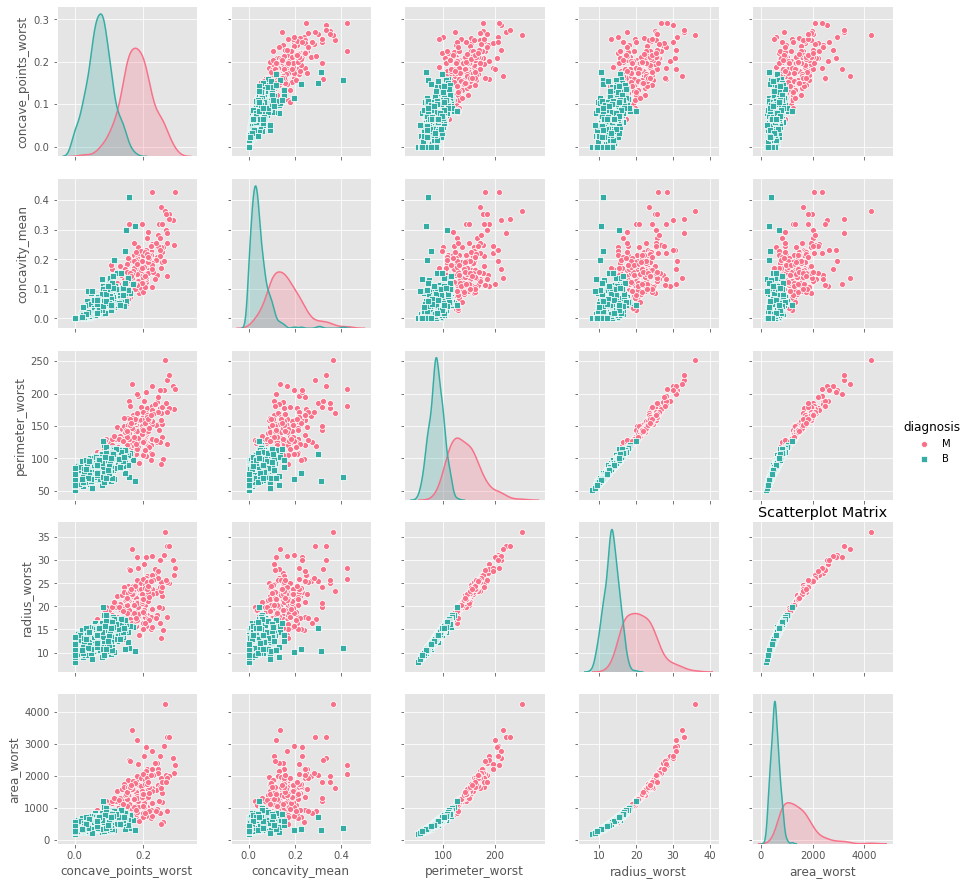

In [9]:
#scatterplot matrix
temp = breast_cancer[['concave_points_worst','concavity_mean', 'perimeter_worst',
                      'radius_worst', 'area_worst', 'diagnosis']]

sns.pairplot(temp, hue='diagnosis', palette='husl', markers=["o", "s"])
plt.title('Scatterplot Matrix');

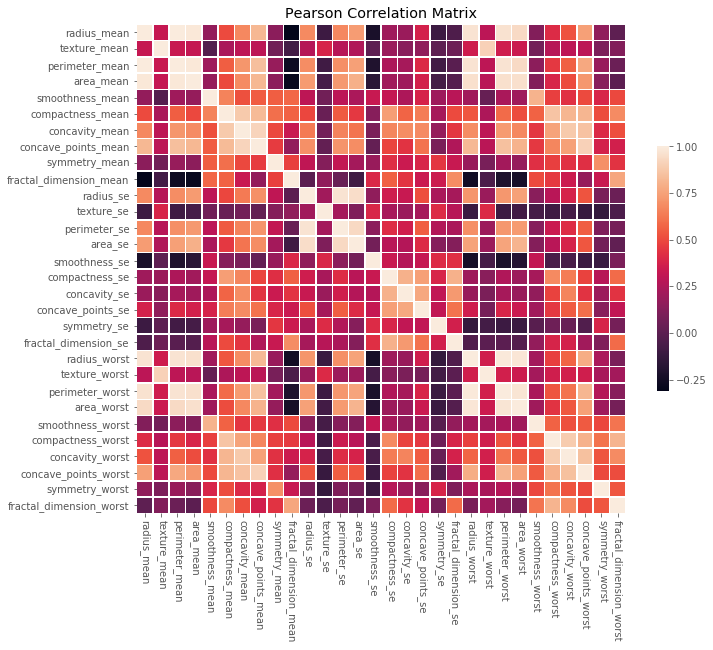

In [10]:
#Pearson correlation matrix
corr = breast_cancer.corr(method = 'pearson') 

f, ax = plt.subplots(figsize=(11, 9))

#draw heatmap
sns.heatmap(corr,
            square=True, 
            xticklabels=True, 
            yticklabels=True,
            linewidths=.5, 
            cbar_kws={"shrink": .5}, 
            ax=ax)

plt.title("Pearson Correlation Matrix")
plt.yticks(rotation = 0)
plt.xticks(rotation = 270);

In [11]:
#change 'M' and 'B' to numerical values
breast_cancer['diagnosis'] = breast_cancer['diagnosis'].map({'M': 1, 'B': 0})

In [12]:
#normalising data

#function to normalise the data set
def normalise_df(df):
    df_norm = pd.DataFrame()
    for col in df:
        if col in df.select_dtypes(include=[np.float]):
            df_norm[col]=((df[col] - df[col].min()) / 
            (df[col].max() - df[col].min()))
        else: 
            df_norm[col] = df[col]
    return df_norm

breast_cancer_norm = normalise_df(breast_cancer)
breast_cancer_norm.describe().T

,count,mean,std,min,25%,50%,75%,max
diagnosis,569.0,0.372583,0.483918,0.0,0.000000,0.000000,1.000000,1.0
radius_mean,569.0,0.338222,0.166787,0.0,0.223342,0.302381,0.416442,1.0
texture_mean,569.0,0.323965,0.145453,0.0,0.218465,0.308759,0.408860,1.0
perimeter_mean,569.0,0.332935,0.167915,0.0,0.216847,0.293345,0.416765,1.0
area_mean,569.0,0.216920,0.149274,0.0,0.117413,0.172895,0.271135,1.0
smoothness_mean,569.0,0.394785,0.126967,0.0,0.304595,0.390358,0.475490,1.0
compactness_mean,569.0,0.260601,0.161992,0.0,0.139685,0.224679,0.340531,1.0
concavity_mean,569.0,0.208058,0.186785,0.0,0.069260,0.144189,0.306232,1.0
concave_points_mean,569.0,0.243137,0.192857,0.0,0.100944,0.166501,0.367793,1.0
symmetry_mean,569.0,0.379605,0.138456,0.0,0.282323,0.369697,0.453030,1.0


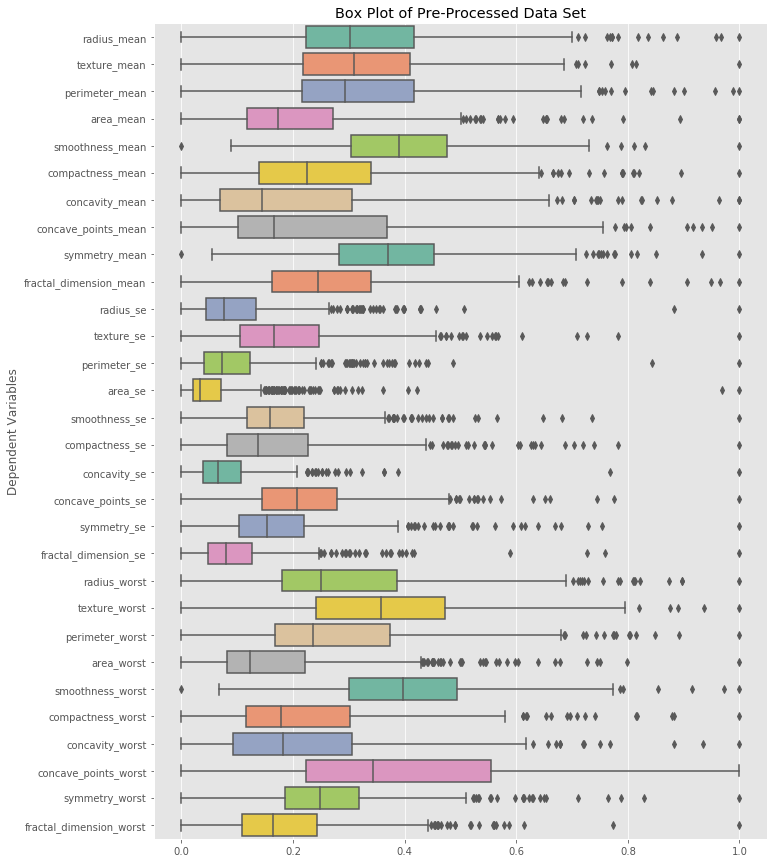

In [13]:
f, ax = plt.subplots(figsize=(11, 15))

ax.set(xlim=(-.05, 1.05))
plt.ylabel('Dependent Variables')
plt.title("Box Plot of Pre-Processed Data Set")
ax = sns.boxplot(data = breast_cancer_norm.drop(['diagnosis'], axis=1),
                 orient = 'h', 
                 palette = 'Set2');

## 3. Train-Test Split

K-Fold Cross Validation will be used to find the best model. The test set will be retained for the end as the unseen data to test the performance of the final model.

In [14]:
y = breast_cancer['diagnosis']
X = breast_cancer.drop('diagnosis', axis=1)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [16]:
len(X_train), len(y_train), len(X_test), len(y_test)

(455, 455, 114, 114)

In [29]:
#reset index for k-fold cv
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

## 4. Building the models
### 4.1 Helper functions

For cancer detection, correctly identifying the positive cases is paramount we wish to minimise false negatives.

For this dataset, the target variable classes in the data are nearly balanced, therefore accuracy is a valid metric to use (this would not be the case if the number of cancer cases was in the minority). As recall provides information about a classifier's performance with respect to false negatives (how many cancer cases were missed), it is an important metric in this case. However, if the classifier predicted everyone as positive then recall would be 100% but the classifier's performance would not be great as we would be telling a lot of people wwho do not have cancer tha that they have it, likely causing emotional distress). And so we would want recall to be as close to 100% as possible, without precision (number of people classified as having cancer that actually have cancer) being too bad. To capture this, F1 score is important, but it is important to check the balance of recall and precision that make up the F1 score generated.

ROC curve is interesting to look at, but the focus is on the false positive rate; our main concern is false negatives, so this is less important than recall.

In [33]:
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier

In [17]:
def kfold_classification(classifier, X, Y):
    skf = StratifiedKFold(n_splits = 5, shuffle = True)
    predictions = []
    Y_actual = []
    predicted_prob = []
    
    for train_subset_index, cv_index in skf.split(X, Y):
        X_features_subset = X.loc[train_subset_index]
        Y_subset = Y.loc[train_subset_index]
        X_features_cv = X.loc[cv_index]
        Y_cv = Y.loc[cv_index]
                
        model = classifier
        model.fit(X_features_subset, Y_subset)
        pred = model.predict(X_features_cv)
        pred_prob = model.predict_proba(X_features_cv)
        
        predictions.append(pred)
        Y_actual.append(Y_cv)
        predicted_prob.append(pred_prob)
    
    predictions = [item for sublist in predictions for item in sublist]
    predicted_proba = np.array(predicted_prob)
    
    act0, act1, act2, act3, act4 = Y_actual[0], Y_actual[1], Y_actual[2], Y_actual[3], Y_actual[4]
    actual = act0.append(act1)
    actual = actual.append(act2)
    actual = actual.append(act3)
    actual = actual.append(act4)

    prob0, prob1, prob2, prob3, prob4 = predicted_prob[0], predicted_prob[1], predicted_prob[2], predicted_prob[3], predicted_prob[4]

    pred_proba = np.concatenate((prob0, prob1))
    pred_proba = np.concatenate((pred_proba, prob2))
    pred_proba = np.concatenate((pred_proba, prob3))
    pred_proba = np.concatenate((pred_proba, prob4))
        
    evaluate_classifier_performance(actual, predictions, pred_proba, 'y')

In [18]:
def evaluate_classifier_performance(actual, predictions, predicted_prob, roc_y_n):
    ### Confusion Matrix
    cm = confusion_matrix(actual, predictions)
    class_names = [0, 1]
    plot_confusion_matrix(cm, class_names)
 
    ### Accuracy scores
    acc = accuracy_score(actual, predictions)
    print("\nAccuracy Score: ", acc)
       
    ### Precision, Recall  
    precision = precision_score(actual, predictions)
    print("\nPrecision: ", precision)
    
    recall = recall_score(actual, predictions)
    print("\nRecall: ", recall)
    
    ### Classification Report
    print("\nClassification Report: \n", classification_report(actual, predictions))

    ### F1 Score
    f1score = f1_score(actual, predictions)
    print("\nF1score: ", f1score)
    
    f1score_weight = f1_score(actual, predictions, average='weighted')
    print("\nWeighted F1-score: ", f1score_weight)
    
    ### ROC-AUC
    if roc_y_n == 'y':
        fpr, tpr, threshold = roc_curve(actual, predicted_prob[:,1])
        roc_auc = auc(fpr, tpr)
        print("\AUC for ROC: ", roc_auc)
        plt.figure()
        plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
        plt.plot([0, 1], [0, 1],'r--')
        plt.xlim([0, 1])
        plt.ylim([0, 1])
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.legend(loc = 'lower right')
        plt.title('Training - Receiver Operating Characteristic')

In [19]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    print('Confusion matrix')
    
    plt.figure(figsize=(20,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)
   
    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

### 4.2 Individual Models
Firstly, a number of classification models will undergo hyperparameter tuning. Then, the classification models will be tested with the data using K-Fold CV, with evaluation metrics generated to see the performance. Then, ensembling will be used to see if this improves performance.

The models to be tested are:
+ SVM
+ Naive Bayes
+ Random Forest
+ KNN
+ Adaboost
+ XGBoost
+ Neural Network - MLPClassifier

#### 4.2.1 SVM

In [23]:
params_svc = {
    'kernel':('linear', 'rbf'),
    'C':[0.001, 0.01, 0.1, 1, 10],
    'gamma':[0.001, 0.01, 0.1, 1]
}

grid_search_svc = GridSearchCV(SVC(), params_svc, cv=5, verbose=0)
grid_search_svc.fit(X_train, y_train)
svc_params = grid_search_svc.best_params_

Confusion matrix


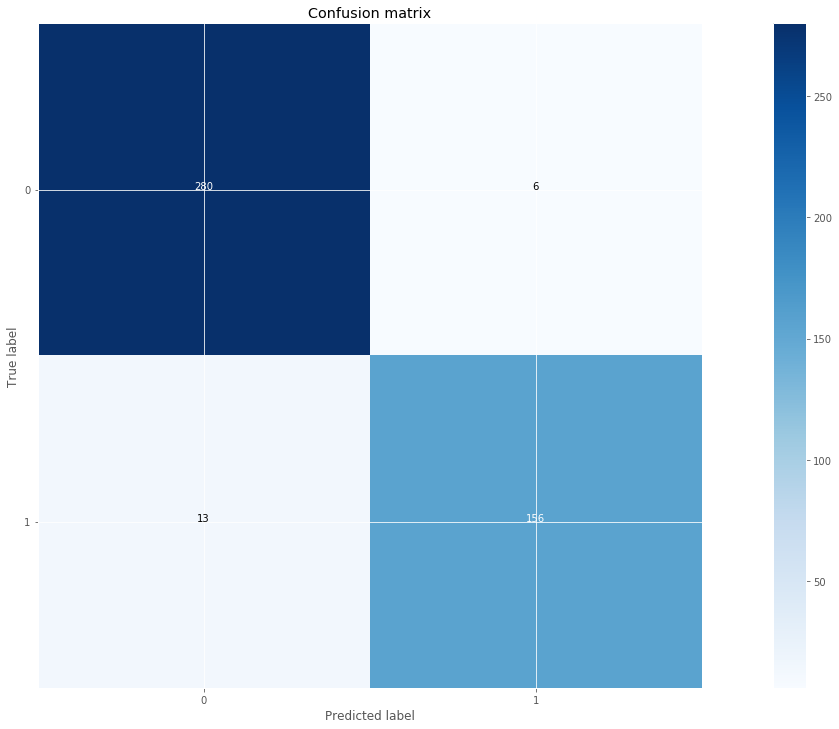


Accuracy Score:  0.9582417582417583

Precision:  0.9629629629629629

Recall:  0.9230769230769231

Classification Report: 
               precision    recall  f1-score   support

           0       0.96      0.98      0.97       286
           1       0.96      0.92      0.94       169

    accuracy                           0.96       455
   macro avg       0.96      0.95      0.95       455
weighted avg       0.96      0.96      0.96       455


F1score:  0.9425981873111782

Weighted F1-score:  0.9580526304412158
\AUC for ROC:  0.9864898415194273


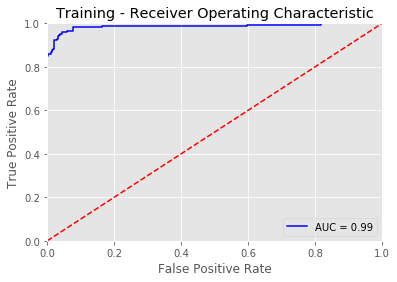

In [34]:
svc = SVC(**svc_params, probability = True)
kfold_classification(svc, X_train, y_train)

#### 4.2.2 Naive Bayes

Confusion matrix


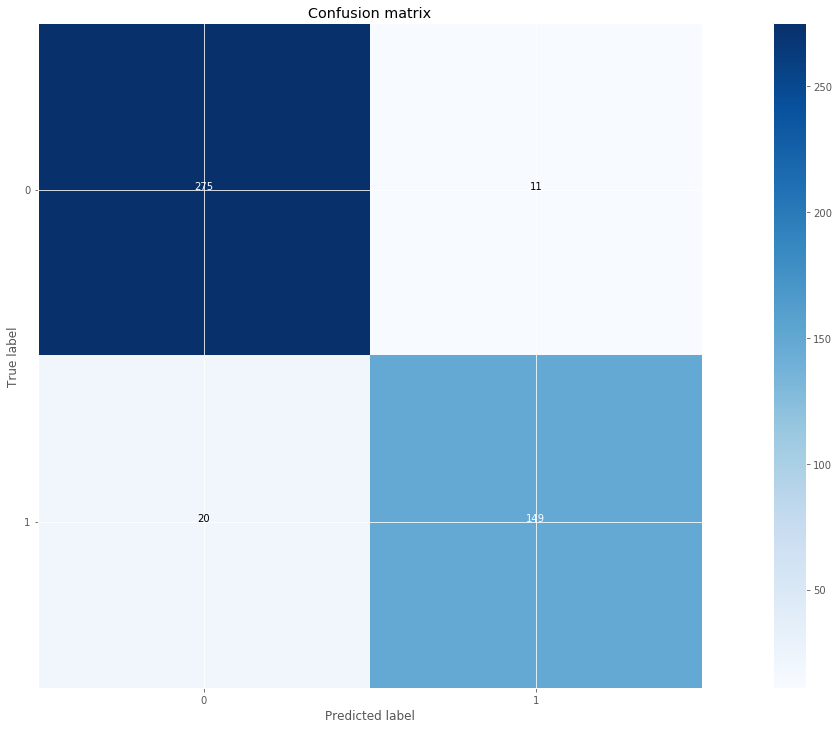


Accuracy Score:  0.9318681318681319

Precision:  0.93125

Recall:  0.8816568047337278

Classification Report: 
               precision    recall  f1-score   support

           0       0.93      0.96      0.95       286
           1       0.93      0.88      0.91       169

    accuracy                           0.93       455
   macro avg       0.93      0.92      0.93       455
weighted avg       0.93      0.93      0.93       455


F1score:  0.9057750759878419

Weighted F1-score:  0.9314639365102617
\AUC for ROC:  0.9829312699135184


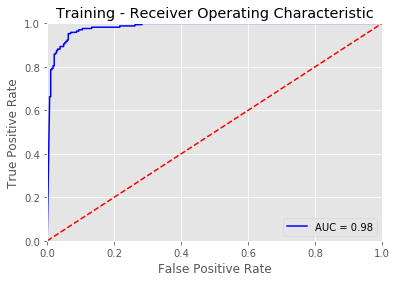

In [35]:
nb = GaussianNB()
kfold_classification(nb, X_train, y_train)

#### 4.2.3 Random Forest

In [44]:
params_rf = {
    'n_estimators': [4, 16, 20, 32, 64, 100, 200],
    'max_features': ['auto','sqrt','log2', None],
    'criterion': ['gini','entropy'],
    'max_depth': [None, 5, 8, 15, 25, 30],
    'min_samples_split': [2, 5, 10, 15, 100],
    'min_samples_leaf': [1, 2, 5, 10],
    'class_weight': ['balanced']
}

grid_search_rf = GridSearchCV(RandomForestClassifier(), params_rf, cv=5, verbose=0)
grid_search_rf.fit(X_train, y_train)
rf_params = grid_search_rf.best_params_

Confusion matrix


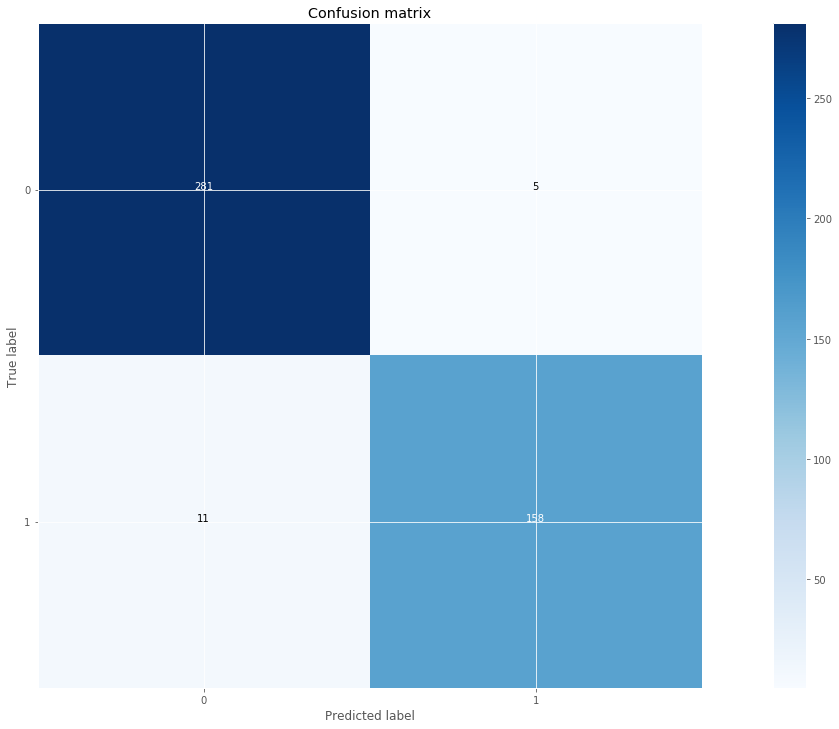


Accuracy Score:  0.9648351648351648

Precision:  0.9693251533742331

Recall:  0.9349112426035503

Classification Report: 
               precision    recall  f1-score   support

           0       0.96      0.98      0.97       286
           1       0.97      0.93      0.95       169

    accuracy                           0.96       455
   macro avg       0.97      0.96      0.96       455
weighted avg       0.96      0.96      0.96       455


F1score:  0.9518072289156626

Weighted F1-score:  0.964699926746035
\AUC for ROC:  0.9887139487731202


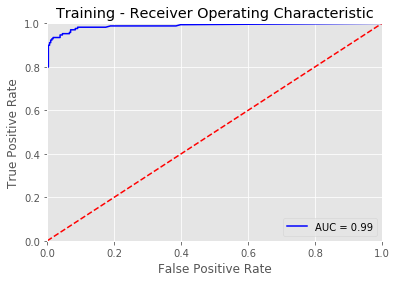

In [45]:
rf = RandomForestClassifier(**rf_params)
kfold_classification(rf, X_train, y_train)

#### 4.2.4 KNN

In [46]:
params_knn = {
    'n_neighbors': list(range(1,30)),
    'p': [1, 2, 3, 4, 5], 
}

grid_search_knn = GridSearchCV(KNeighborsClassifier(), params_knn, cv=5, verbose=0)
grid_search_knn.fit(X_train, y_train)
knn_params = grid_search_knn.best_params_

Confusion matrix


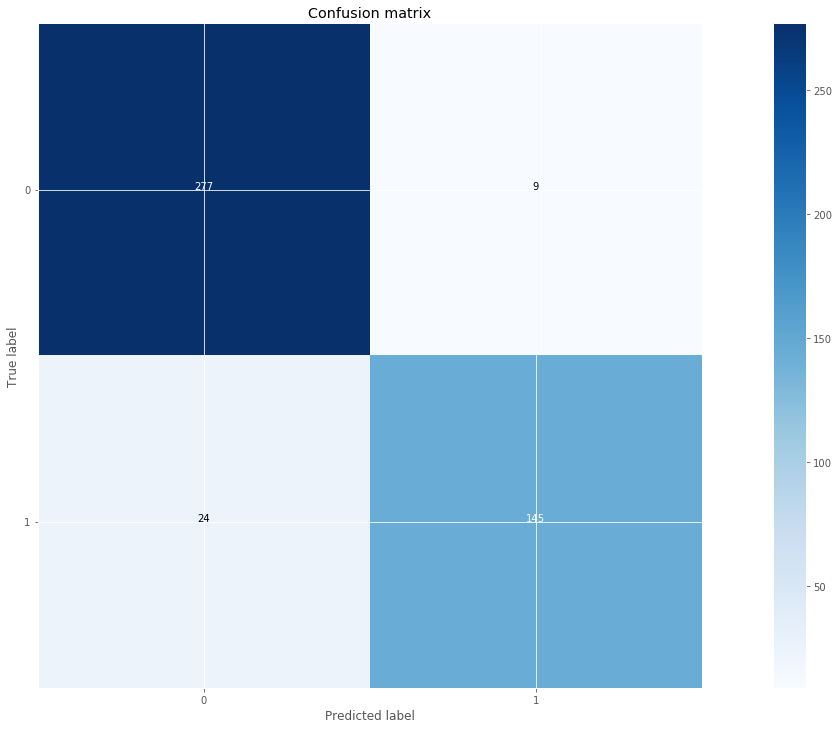


Accuracy Score:  0.9274725274725275

Precision:  0.9415584415584416

Recall:  0.8579881656804734

Classification Report: 
               precision    recall  f1-score   support

           0       0.92      0.97      0.94       286
           1       0.94      0.86      0.90       169

    accuracy                           0.93       455
   macro avg       0.93      0.91      0.92       455
weighted avg       0.93      0.93      0.93       455


F1score:  0.8978328173374613

Weighted F1-score:  0.9267151243174577
\AUC for ROC:  0.913259817105971


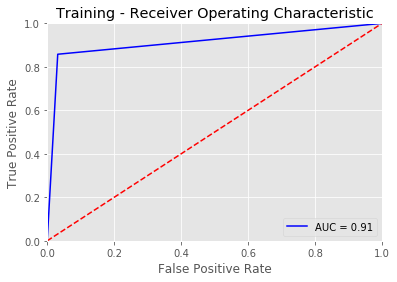

In [47]:
knn = KNeighborsClassifier(**knn_params)
kfold_classification(knn, X_train, y_train)

#### 4.2.5 Adaboost

In [48]:
params_ada = {
    'n_estimators': [1, 2, 4, 8, 16, 32, 64, 100, 200] 
}

grid_search_ada = GridSearchCV(AdaBoostClassifier(), params_ada, cv=5, verbose=0)
grid_search_ada.fit(X_train, y_train)
ada_params = grid_search_ada.best_params_

Confusion matrix


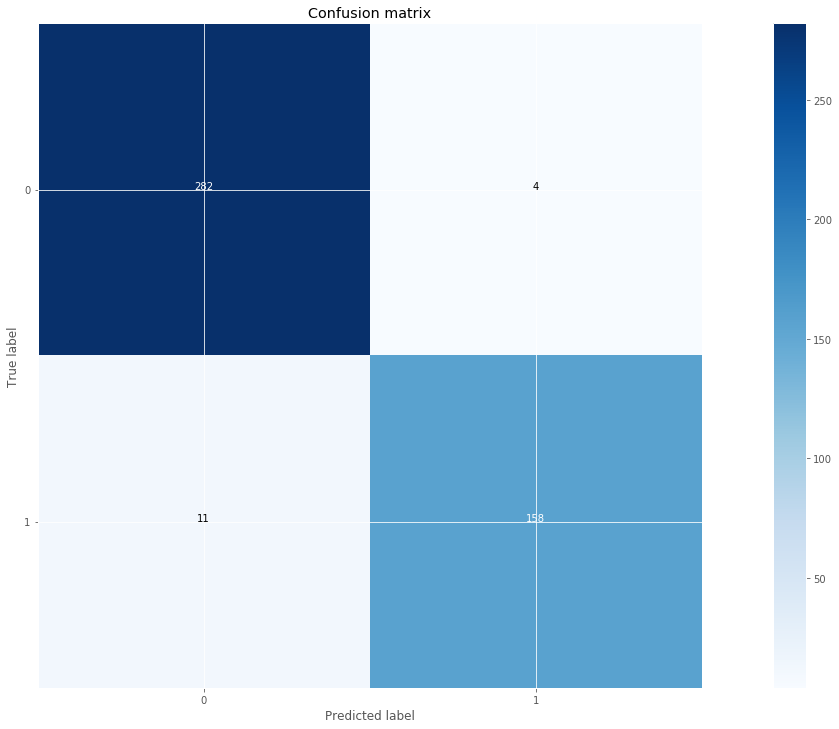


Accuracy Score:  0.967032967032967

Precision:  0.9753086419753086

Recall:  0.9349112426035503

Classification Report: 
               precision    recall  f1-score   support

           0       0.96      0.99      0.97       286
           1       0.98      0.93      0.95       169

    accuracy                           0.97       455
   macro avg       0.97      0.96      0.96       455
weighted avg       0.97      0.97      0.97       455


F1score:  0.9546827794561933

Weighted F1-score:  0.9668836556114861
\AUC for ROC:  0.9890139446352464


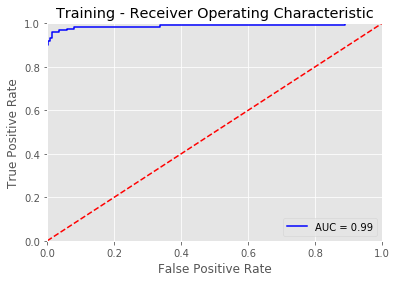

In [49]:
ada = AdaBoostClassifier(**ada_params)
kfold_classification(ada, X_train, y_train)

#### 4.2.6 XGBoost

In [51]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

params_xgb = {
    'max_depth': range(3,10,2),
    'min_child_weight': range(1,6,2),
    'gamma': [i/10.0 for i in range(0,5)],
    'subsample': [i/10.0 for i in range(6,10)],
    'colsample_bytree': [i/10.0 for i in range(6,10)],
    'reg_alpha': [1e-5, 1e-2, 0.1, 1, 100] 
}

grid_search_xgb = GridSearchCV(XGBClassifier(seed=42), params_xgb, cv=5, verbose=0)
grid_search_xgb.fit(X_train, y_train)
xgb_params = grid_search_xgb.best_params_

Confusion matrix


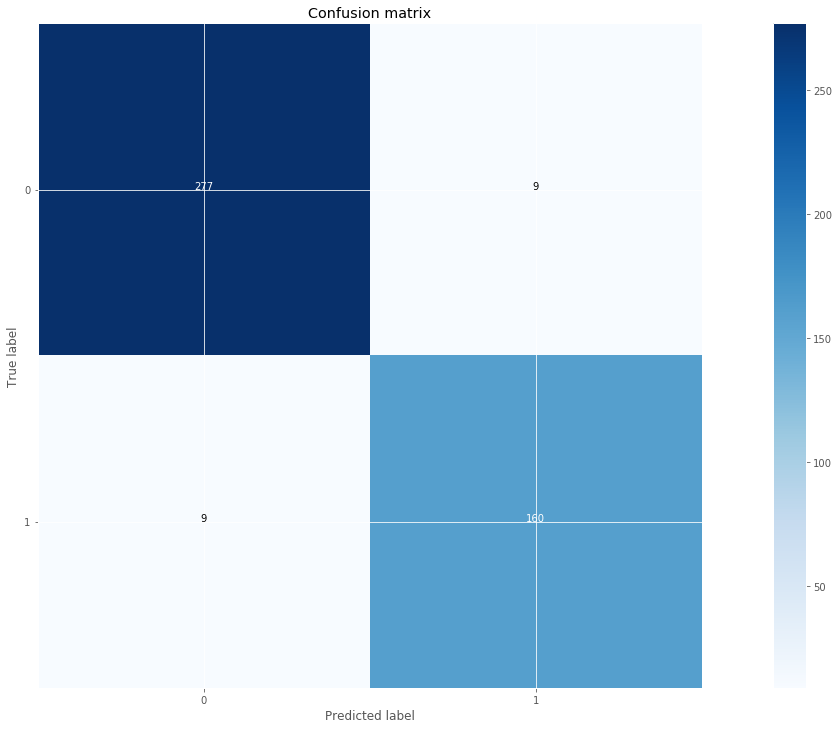


Accuracy Score:  0.9604395604395605

Precision:  0.9467455621301775

Recall:  0.9467455621301775

Classification Report: 
               precision    recall  f1-score   support

           0       0.97      0.97      0.97       286
           1       0.95      0.95      0.95       169

    accuracy                           0.96       455
   macro avg       0.96      0.96      0.96       455
weighted avg       0.96      0.96      0.96       455


F1score:  0.9467455621301775

Weighted F1-score:  0.9604395604395605
\AUC for ROC:  0.9894277320312824


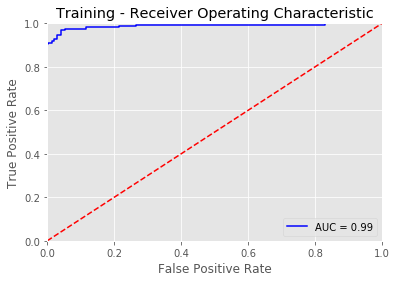

In [52]:
xgb = XGBClassifier(**xgb_params, seed=42)
kfold_classification(xgb, X_train, y_train)

#### 4.2.7 MLPClassifier

In [57]:
from sklearn.neural_network import MLPClassifier
import warnings
warnings.filterwarnings("ignore")

params_nn = {
    'activation': ['identity', 'logistic', 'tanh', 'relu'],
    'solver': ['lbfgs', 'sgd', 'adam'],
    'alpha': [0.0001, 0.001, 0.01, 0.1],
    'early_stopping': [True],
    'max_iter': [5000]
}

grid_search_nn = GridSearchCV(MLPClassifier(random_state=42), params_nn, cv=5, verbose=0)
grid_search_nn.fit(X_train, y_train)
print(grid_search_nn.best_params_)

{'activation': 'tanh', 'alpha': 0.1, 'early_stopping': True, 'max_iter': 5000, 'solver': 'lbfgs'}


In [58]:
nn_params = grid_search_nn.best_params_

Confusion matrix


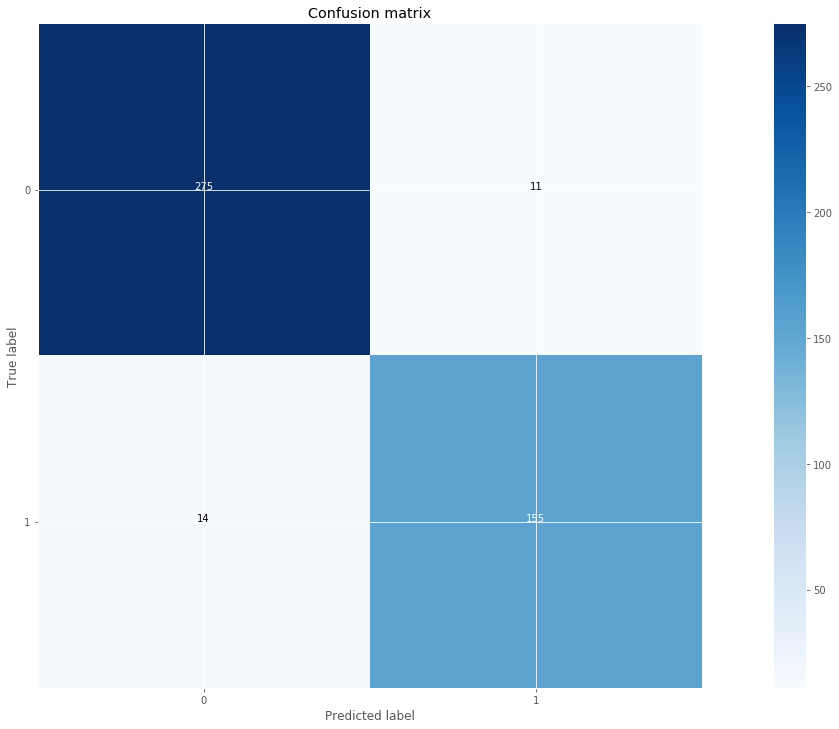


Accuracy Score:  0.945054945054945

Precision:  0.9337349397590361

Recall:  0.9171597633136095

Classification Report: 
               precision    recall  f1-score   support

           0       0.95      0.96      0.96       286
           1       0.93      0.92      0.93       169

    accuracy                           0.95       455
   macro avg       0.94      0.94      0.94       455
weighted avg       0.94      0.95      0.94       455


F1score:  0.9253731343283581

Weighted F1-score:  0.9449522573468063
\AUC for ROC:  0.9852071005917159


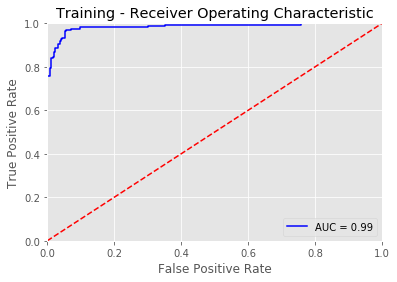

In [59]:
nn = MLPClassifier(**nn_params, random_state=42)
kfold_classification(nn, X_train, y_train)

### 4.3 Stacking 

Stacking that will be tested are:
+ VotingClassifier
+ mlextend simple stacking
+ mlextend with probabiltiies as meta features

#### 4.3.1 VotingClassifier

In [65]:
svc = SVC(**svc_params, probability=True)
nb = GaussianNB()
rf = RandomForestClassifier(**rf_params)
knn = KNeighborsClassifier(**knn_params)
ada = AdaBoostClassifier(**ada_params)
xgb = XGBClassifier(**xgb_params, seed=42)
nn = MLPClassifier(**nn_params, random_state=42)

In [66]:
skf = StratifiedKFold(n_splits = 5, shuffle = True)
predictions = []
actual = []
predicted_prob = []

for train_subset_index, cv_index in skf.split(X_train, y_train):
    X_features_subset = X_train.iloc[train_subset_index]
    Y_subset = y_train.iloc[train_subset_index]
    X_features_cv = X_train.iloc[cv_index]
    Y_cv = y_train.iloc[cv_index]
    
    clf = VotingClassifier(estimators=[('svc', svc),
                                       ('nb', nb),
                                       ('rf', rf),
                                       ('knn',knn),
                                       ('ada',ada),
                                       ('xgb', xgb),
                                       ('nn', nn)],
                           voting='soft')
    clf.fit(X_features_subset, Y_subset)
    pred = clf.predict(X_features_cv)
    pred_prob = clf.predict_proba(X_features_cv)
    
    predictions.append(pred)
    actual.append(Y_cv)    
    predicted_prob.append(pred_prob)
    
predictions = [item for sublist in predictions for item in sublist]
predicted_proba = np.array(predicted_prob)
    
act0, act1, act2, act3, act4 = actual[0], actual[1], actual[2], actual[3], actual[4]
actual = act0.append(act1)
actual = actual.append(act2)
actual = actual.append(act3)
actual = actual.append(act4)

prob0, prob1, prob2, prob3, prob4 = predicted_prob[0], predicted_prob[1], predicted_prob[2], predicted_prob[3], predicted_prob[4]

pred_proba = np.concatenate((prob0, prob1))
pred_proba = np.concatenate((pred_proba, prob2))
pred_proba = np.concatenate((pred_proba, prob3))
pred_proba = np.concatenate((pred_proba, prob4))

Confusion matrix


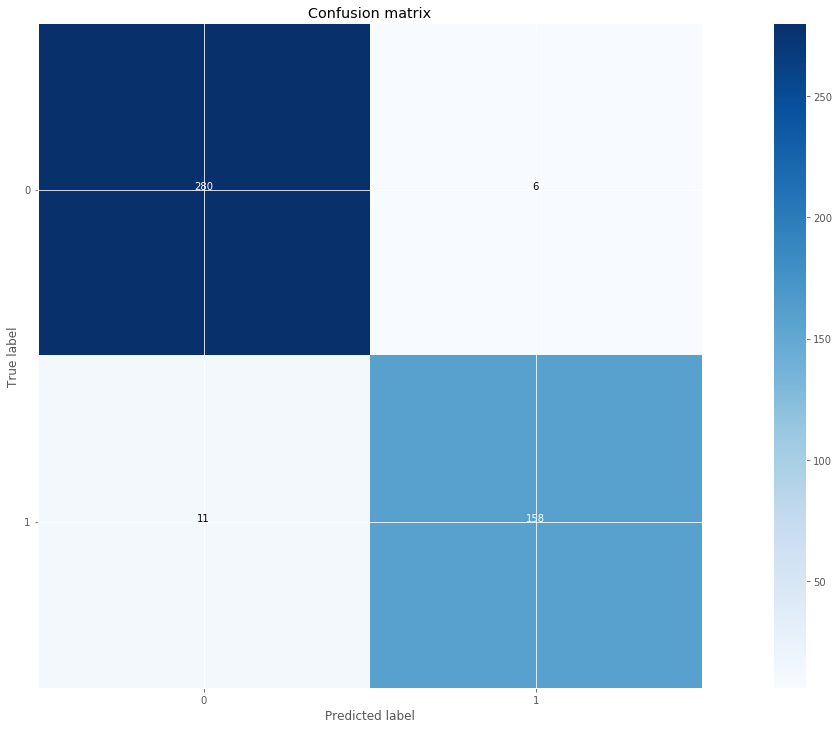


Accuracy Score:  0.9626373626373627

Precision:  0.9634146341463414

Recall:  0.9349112426035503

Classification Report: 
               precision    recall  f1-score   support

           0       0.96      0.98      0.97       286
           1       0.96      0.93      0.95       169

    accuracy                           0.96       455
   macro avg       0.96      0.96      0.96       455
weighted avg       0.96      0.96      0.96       455


F1score:  0.948948948948949

Weighted F1-score:  0.9625187455343436
\AUC for ROC:  0.9914139115322547


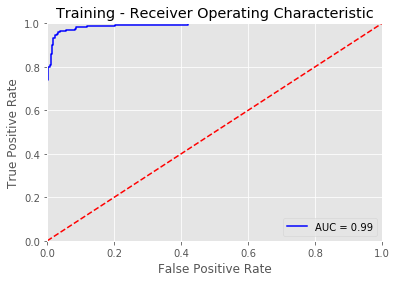

In [68]:
evaluate_classifier_performance(actual, predictions, pred_proba, 'y')

#### 4.3.2 mlxtend simple stacking

In [70]:
from mlxtend.classifier import StackingClassifier

lr = LogisticRegression()

skf = StratifiedKFold(n_splits = 5, shuffle = True)
predictions = []
actual = []
predicted_prob = []

for train_subset_index, cv_index in skf.split(X_train, y_train):
    X_features_subset = X_train.iloc[train_subset_index]
    Y_subset = y_train.iloc[train_subset_index]
    X_features_cv = X_train.iloc[cv_index]
    Y_cv = y_train.iloc[cv_index]
    
    clf = StackingClassifier(classifiers=[svc, nb, rf, knn, ada, xgb, nn],
                             meta_classifier=lr)
    clf.fit(X_features_subset, Y_subset)
    pred = clf.predict(X_features_cv)
    pred_prob = clf.predict_proba(X_features_cv)
    
    predictions.append(pred)
    actual.append(Y_cv) 
    predicted_prob.append(pred_prob)
    
predictions = [item for sublist in predictions for item in sublist]
predicted_proba = np.array(predicted_prob)
    
act0, act1, act2, act3, act4 = actual[0], actual[1], actual[2], actual[3], actual[4]
actual = act0.append(act1)
actual = actual.append(act2)
actual = actual.append(act3)
actual = actual.append(act4)

prob0, prob1, prob2, prob3, prob4 = predicted_prob[0], predicted_prob[1], predicted_prob[2], predicted_prob[3], predicted_prob[4]

pred_proba = np.concatenate((prob0, prob1))
pred_proba = np.concatenate((pred_proba, prob2))
pred_proba = np.concatenate((pred_proba, prob3))
pred_proba = np.concatenate((pred_proba, prob4))

Confusion matrix


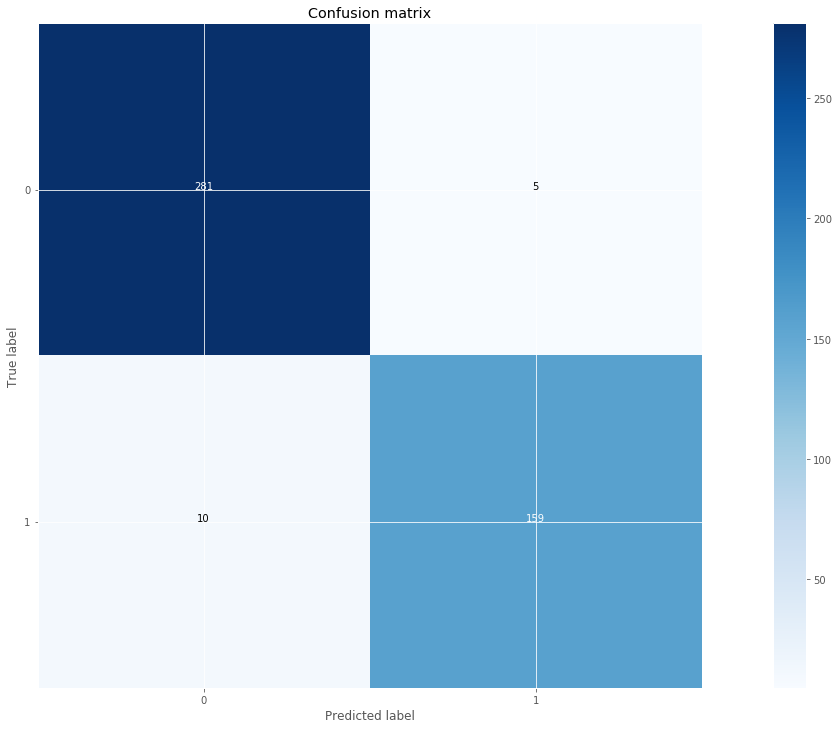


Accuracy Score:  0.967032967032967

Precision:  0.9695121951219512

Recall:  0.9408284023668639

Classification Report: 
               precision    recall  f1-score   support

           0       0.97      0.98      0.97       286
           1       0.97      0.94      0.95       169

    accuracy                           0.97       455
   macro avg       0.97      0.96      0.96       455
weighted avg       0.97      0.97      0.97       455


F1score:  0.954954954954955

Weighted F1-score:  0.9669283048832442
\AUC for ROC:  0.9863967393553192


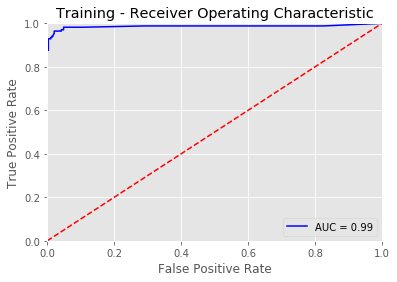

In [71]:
evaluate_classifier_performance(actual, predictions, pred_proba, 'y')

#### 4.3.3 mlxtend and using probabilities as meta features

In [72]:
lr = LogisticRegression()

skf = StratifiedKFold(n_splits = 5, shuffle = True)
predictions = []
actual = []
predicted_prob = []

for train_subset_index, cv_index in skf.split(X_train, y_train):
    X_features_subset = X_train.iloc[train_subset_index]
    Y_subset = y_train.iloc[train_subset_index]
    X_features_cv = X_train.iloc[cv_index]
    Y_cv = y_train.iloc[cv_index]
    
    clf = StackingClassifier(classifiers=[svc, nb, rf, knn, ada, xgb, nn],
                             use_probas=True,
                             average_probas=False,
                             meta_classifier=lr)
    clf.fit(X_features_subset, Y_subset)
    pred = clf.predict(X_features_cv)
    pred_prob = clf.predict_proba(X_features_cv)
    
    predictions.append(pred)
    actual.append(Y_cv)    
    predicted_prob.append(pred_prob)
    
predictions = [item for sublist in predictions for item in sublist]
predicted_proba = np.array(predicted_prob)
    
act0, act1, act2, act3, act4 = actual[0], actual[1], actual[2], actual[3], actual[4]
actual = act0.append(act1)
actual = actual.append(act2)
actual = actual.append(act3)
actual = actual.append(act4)

prob0, prob1, prob2, prob3, prob4 = predicted_prob[0], predicted_prob[1], predicted_prob[2], predicted_prob[3], predicted_prob[4]

pred_proba = np.concatenate((prob0, prob1))
pred_proba = np.concatenate((pred_proba, prob2))
pred_proba = np.concatenate((pred_proba, prob3))
pred_proba = np.concatenate((pred_proba, prob4))

Confusion matrix


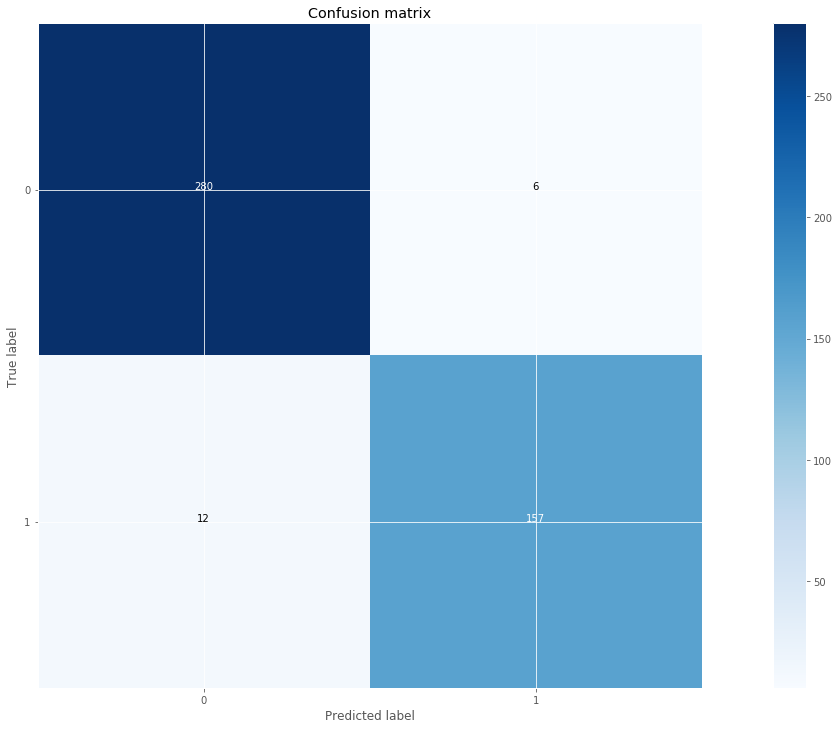


Accuracy Score:  0.9604395604395605

Precision:  0.9631901840490797

Recall:  0.9289940828402367

Classification Report: 
               precision    recall  f1-score   support

           0       0.96      0.98      0.97       286
           1       0.96      0.93      0.95       169

    accuracy                           0.96       455
   macro avg       0.96      0.95      0.96       455
weighted avg       0.96      0.96      0.96       455


F1score:  0.9457831325301205

Weighted F1-score:  0.9602874175892894
\AUC for ROC:  0.9887449828278231


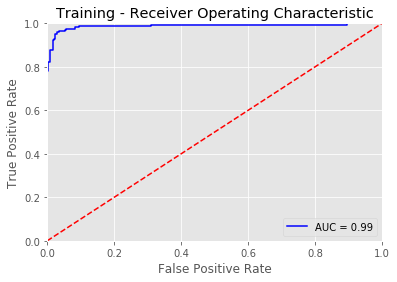

In [73]:
evaluate_classifier_performance(actual, predictions, pred_proba, 'y')

## 5. Building and testing the final model

From the above, the best performing classifier on the training data, using k-fold cross validation, is XGBoost. Although this classifier does not have the highest accuracy rate, it has the lowest rate of false negatives, as indicated by it having the highest recall of 0.9467.

XGBoost will now be trained on all of the training set and the final model used to predict diagnosis of the test set, and performance evaluated.

In [75]:
xgb_final = XGBClassifier(**xgb_params, seed=42)
xgb_final

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, gamma=0.1,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=3, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=1e-05, reg_lambda=1, scale_pos_weight=1, seed=42,
              silent=None, subsample=0.8, verbosity=1)

In [76]:
xgb_final.fit(X_train, y_train)
preds = xgb_final.predict(X_test)

Confusion matrix


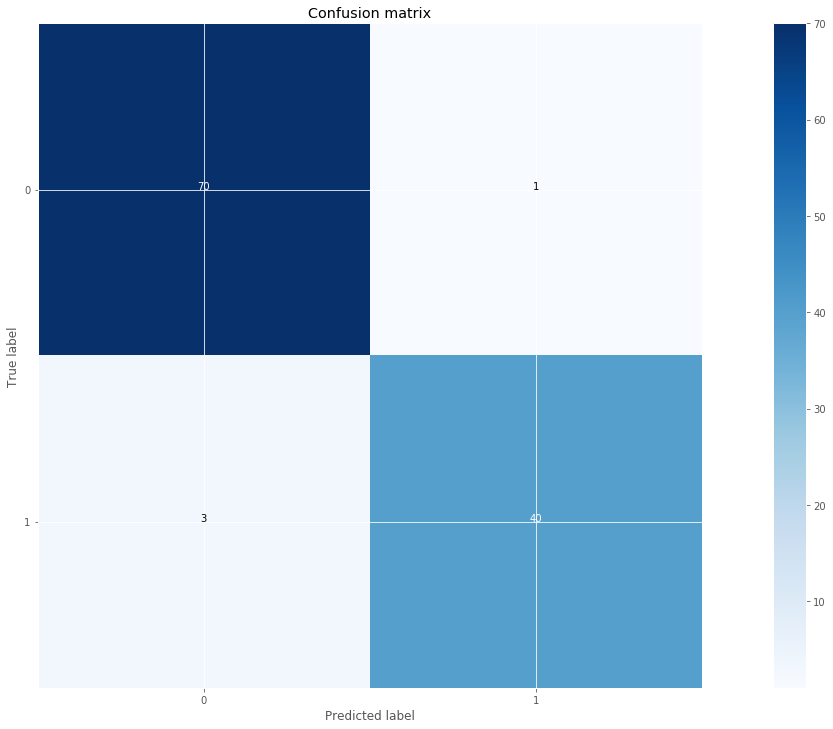


Accuracy Score:  0.9649122807017544

Precision:  0.975609756097561

Recall:  0.9302325581395349

Classification Report: 
               precision    recall  f1-score   support

           0       0.96      0.99      0.97        71
           1       0.98      0.93      0.95        43

    accuracy                           0.96       114
   macro avg       0.97      0.96      0.96       114
weighted avg       0.97      0.96      0.96       114


F1score:  0.9523809523809524


In [77]:
### Confusion Matrix
cm = confusion_matrix(y_test, preds)
class_names = [0, 1]
plot_confusion_matrix(cm, class_names)
 
### Accuracy scores
acc = accuracy_score(y_test, preds)
print("\nAccuracy Score: ", acc)
       
### Precision, Recall  
precision = precision_score(y_test, preds)
print("\nPrecision: ", precision)
    
recall = recall_score(y_test, preds)
print("\nRecall: ", recall)
    
### Classification Report
print("\nClassification Report: \n", classification_report(y_test, preds))

### F1 Score
f1score = f1_score(y_test, preds)
print("\nF1score: ", f1score)

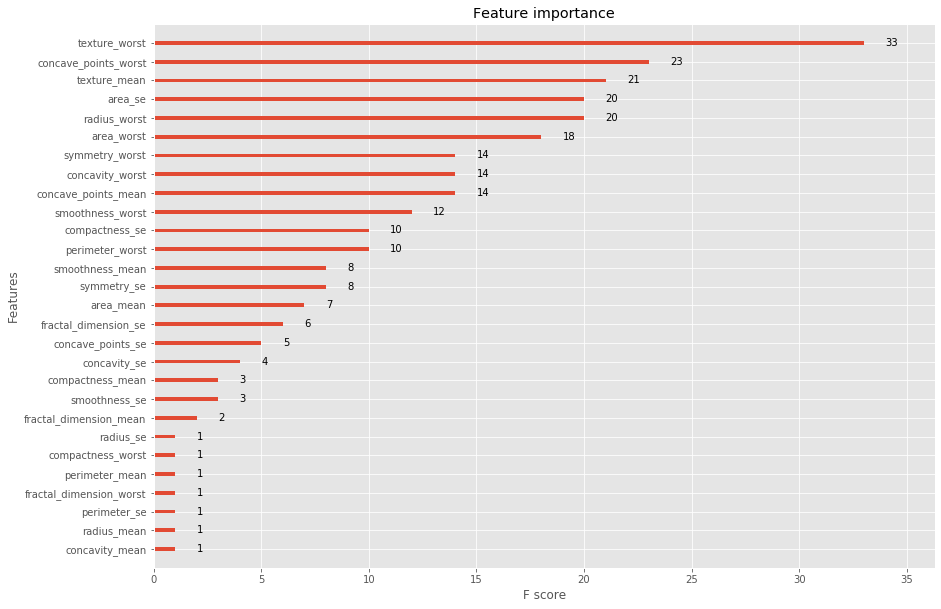

In [91]:
from xgboost import plot_importance
import matplotlib.pyplot as plt

# plot feature importance
plt.rcParams["figure.figsize"] = (14, 10)
#plot_importance(booster=booster)
plot_importance(xgb_final)
plt.show()

The trained XGBClassifier achieved an accuracy of 96.49%, with a recall of 93.02%, which is not quite as good as on the training data, but has resulted in only 3 false negatives out of 43 total 'Malignant' diagnoses. Obviously, in the case of cancer, a single false negative is too many as it is incredibly important that all those who do have cancer are successfully diagnosed and so can receive treatment before it progresses. However, this is a good start. 

Improvements may be made if additional data were available, in the form of cases. Also, further patient information may further improve the model - only data related to the growth are included here, but patient information may also be relevant as those variables may increase or decrease the likelihood of someone having a growth and it being malignant.